In [1]:
import os
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

## Better time series data

The `04_minmax_test.py` script logs CPU temperatures while cycling between cooldown and warmup. During cooldown it stays at 0% usage and waits 30 seconds to reach a minimum. When warming up, the script has the CPU stay at 100% to find its maximum temperature.

By letting the temperatures rise and fall, we can see how warmer cases behave at lower temperatures. When you're using your pi with a closed case, odds are it never gets the chance to cool down. With this more balanced data we can get a better idea of how much heat each case top dissipates.

The tests were only run on five different tops: fully-open, holed top, solid top, exhaust fan, and intake fan.

In [2]:
raw_files = [x for x in os.listdir("./data") if re.match(r"^minmax_[01]{10}_w\d+.csv$", x)]

raw = pd.concat([pd.read_csv(f"./data/{x}").assign(filename=x) for x in raw_files])

def dummify_filename(filename):
    # The filenames have an underscore
    # Split on _ and keep the second half
    code = filename.split("_")[1]
    # Get rid of non-digit characters
    code = re.sub(r"\D", "", code)
    # Break the code into a list of 0/1 integers
    flags = [int(x) for x in list(code)]
    # List the dummy labels
    keys = ["case_under",
            "case_frame",
            "case_cable",
            "case_gpio",
            "top_solid",
            "top_holed",
            "top_intake",
            "top_exhaust",
            "heatsink_main",
            "heatsink_sub"
           ]
    # Output into a dictionary, which pandas can transform into a dataframe
    values = {k:v for k,v in zip(keys, flags)}
    values["filename"] = filename
    return values

# Only get unique filenames
# Feed them into the dummify function
flags = pd.DataFrame([dummify_filename(x) for x in raw.filename.drop_duplicates()])

# The .join() method joins on indexes
df_flagged = raw.merge(flags, on = "filename")

Create a useful list of filenames.

In [3]:
list_of_files = list(df_flagged.filename.unique())

list_of_files

['minmax_1111010011_w30.csv',
 'minmax_1111000111_w30.csv',
 'minmax_1111001011_w30.csv',
 'minmax_1111100011_w30.csv',
 'minmax_1111000011_w30.csv']

Also create a list of labelled names. These give better plot labels below.

In [4]:
def dummy_namer(filename):
    code = filename.split("_")[1]
    dummies = list(code)
    dummies = [int(x) for x in dummies]
    names = ["case_under",
            "case_frame",
            "case_cable",
            "case_gpio",
            "top_solid",
            "top_holed",
            "top_intake",
            "top_exhaust",
            "heatsink_main",
            "heatsink_sub"]
    # modification since we only test tops
    dummies = dummies[4:8]
    names = names[4:8]
    if dummies == [0, 0, 0, 0]:
        return "open_top"
    else:
        return ", ".join([x for x, y in zip(names, dummies) if y == 1])

list_of_names = [dummy_namer(x) for x in list_of_files]

list_of_names

['top_holed', 'top_exhaust', 'top_intake', 'top_solid', 'open_top']

In [5]:
names_df = pd.DataFrame({
    "filename" : list_of_files,
    "name" : list_of_names
})

df_named = df_flagged.merge(names_df, on = "filename")

df_named

,datetime,obs_type,usage,temp,filename,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,top_exhaust,heatsink_main,heatsink_sub,name
0,2020-08-07 19:44:42.158850,cooldown,0.6,38.628,minmax_1111010011_w30.csv,1,1,1,1,0,1,0,0,1,1,top_holed
1,2020-08-07 19:44:43.162483,cooldown,0.0,38.628,minmax_1111010011_w30.csv,1,1,1,1,0,1,0,0,1,1,top_holed
2,2020-08-07 19:44:44.165944,cooldown,0.0,38.628,minmax_1111010011_w30.csv,1,1,1,1,0,1,0,0,1,1,top_holed
3,2020-08-07 19:44:45.169402,cooldown,0.0,38.628,minmax_1111010011_w30.csv,1,1,1,1,0,1,0,0,1,1,top_holed
4,2020-08-07 19:44:46.172915,cooldown,0.2,38.628,minmax_1111010011_w30.csv,1,1,1,1,0,1,0,0,1,1,top_holed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37323,2020-08-06 20:55:17.251833,warmup,100.0,81.130,minmax_1111000011_w30.csv,1,1,1,1,0,0,0,0,1,1,open_top
37324,2020-08-06 20:55:18.254223,warmup,100.0,80.592,minmax_1111000011_w30.csv,1,1,1,1,0,0,0,0,1,1,open_top
37325,2020-08-06 20:55:19.256615,warmup,100.0,81.130,minmax_1111000011_w30.csv,1,1,1,1,0,0,0,0,1,1,open_top
37326,2020-08-06 20:55:20.259066,warmup,93.7,81.130,minmax_1111000011_w30.csv,1,1,1,1,0,0,0,0,1,1,open_top


### tl;dr results

Here are the minimum and maximum temperatures from the data collected. The script writes these values when it switches between cooldown and warmup cycles. These are means calculated over two hours per case configuration.

The blue dotted line indicates the raspberry pi's soft throttle threshold, which is when the CPU starts slowing down a little to stay cool.

The red dotted line is the hard-coded maximum temperature of the raspberry pi CPU. The CPU will do everything it can to stay under this, so getting close to it is not a good idea.

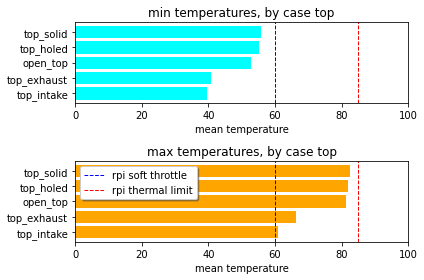

In [6]:
minmax_means = (
    df_named
    .loc[df_named.obs_type.isin(["min", "max"])]
    .groupby(["obs_type", "name"])["temp"]
    .mean()
    .reset_index())

fig, axs = plt.subplots(2, 1)
for n, (obs_type, color) in enumerate(zip(["min", "max"], ["cyan", "orange"])):
    data = minmax_means.loc[minmax_means.obs_type == obs_type].sort_values("temp")
    axs[n].barh(data.name, data.temp, color=color)
    axs[n].set_xlim(0, 100)
    axs[n].set_xlabel("mean temperature")
    axs[n].set_title(f"{obs_type} temperatures, by case top")
    axs[n].axvline(60, ls="--", lw=1, color="b", label="rpi soft throttle")
    axs[n].axvline(85, ls="--", lw=1, color="r", label="rpi thermal limit")
fig.tight_layout()
plt.legend(loc='best', shadow=True, fancybox=True, markerscale=100)
plt.savefig("./images/exp2_minmax_by_top.png")
plt.show()

### Preparing the time series data

As before, we just have to convert the datestamps to proper pandas `DatetimeIndex`. Once that's done, we can treat the data like a proper time series dataset.

The code below also drops any duplicate timestamps and drops them if they exist.

In [7]:
df_dt = df_named.copy()

# Only keep warmup and cooldown rows
df_dt = df_dt.loc[df_dt.obs_type.isin(["warmup", "cooldown"])]

# Convert the datetime column to a datetime dtype
# This works fine since the datetime is already in a standard format
df_dt["datetime"] = pd.to_datetime(df_dt["datetime"])
df_dt["datetime"] = pd.DatetimeIndex(df_dt["datetime"]).round("s")

# Set datetime as the index
df_dt = df_dt.set_index("datetime")

# Do we have any duplicated indexes?
# It's a good idea to include this printout for information purposes
print(f"We have duplicate indexes: {any(df_dt.index.duplicated())}")

# Drop duplicate indexes, just in case
# I learned something: the tilde sign in Python is bitwise not
# ie: "vectorized" not if you're from R
df_dt = df_dt.loc[~df_dt.index.duplicated()]

df_dt.describe()

We have duplicate indexes: False


,usage,temp,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,top_exhaust,heatsink_main,heatsink_sub
count,37170.000000,37170.000000,37170.0,37170.0,37170.0,37170.0,37170.000000,37170.000000,37170.000000,37170.000000,37170.0,37170.0
mean,49.177926,61.644094,1.0,1.0,1.0,1.0,0.195319,0.205811,0.204197,0.195319,1.0,1.0
std,49.795657,12.098668,0.0,0.0,0.0,0.0,0.396451,0.404299,0.403119,0.396451,0.0,0.0
min,0.000000,36.476000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,0.000000,54.768000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0
50%,1.500000,60.148000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0
75%,100.000000,70.908000,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0
max,100.000000,83.282000,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0


### Visualize the time series

By looking at the data this way, we're making sure it's nice and regular. Our data collection goal was to get data with plenty of examples of the CPU warming up and cooling down. We want to confirm that things are as expected, and that there's nothing unexpected.

Our original dataset had a problem with heat accumulation, with temperatures trending up with closed cases. This is less noticeable now since the cases have time to cool.

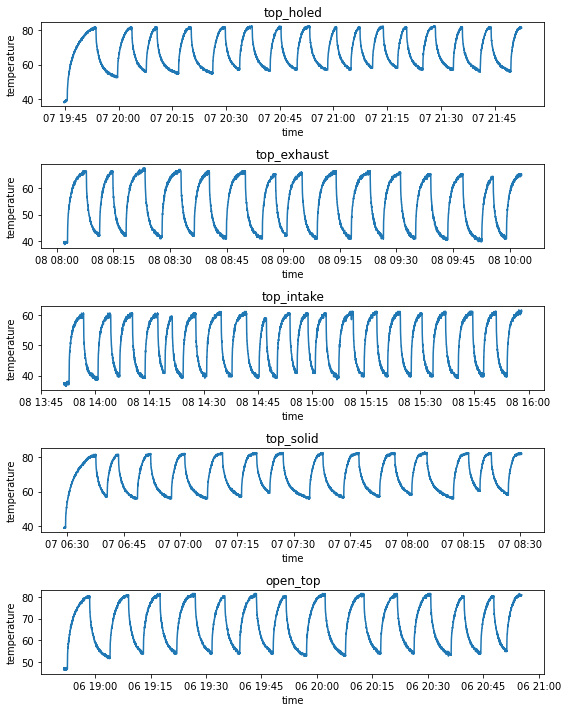

In [8]:
fig, axs = plt.subplots(len(list_of_files), 1, figsize=(8, 10))
for n, name in enumerate(list_of_names):
    axs[n].plot(df_dt.loc[df_dt.name == name].index,
                df_dt.loc[df_dt.name == name].temp)
    axs[n].set_xlabel("time")
    axs[n].set_ylabel("temperature")
    axs[n].set_title(name)
fig.tight_layout()
plt.savefig("./images/exp2_stable_time_series.png")
plt.show()

### Create lags

We're going to create lagged variables. A lag of 1 here is a lag of 1 second since we took measurements each second.

The model below will take data lagged by 1 second and try to predict the current CPU temperature. By including some extra lags, we can play with the model a bit.

In [9]:
dt_lag = df_dt.copy()

# Create lags
dt_lag["temp_1"] = dt_lag.temp.shift(1, freq="S")
dt_lag["temp_3"] = dt_lag.temp.shift(3, freq="S")
dt_lag["temp_5"] = dt_lag.temp.shift(5, freq="S")
dt_lag["usage_1"] = dt_lag.usage.shift(1, freq="S")
dt_lag["usage_3"] = dt_lag.usage.shift(3, freq="S")
dt_lag["usage_5"] = dt_lag.usage.shift(5, freq="S")

# Create a throtling dummy
# The raspberry pi starts to throttle at 60C
dt_lag["throttle_1"] = [1 if temp >= 60 else 0 for temp in dt_lag.temp_1]
dt_lag["throttle_3"] = [1 if temp >= 60 else 0 for temp in dt_lag.temp_3]
dt_lag["throttle_5"] = [1 if temp >= 60 else 0 for temp in dt_lag.temp_5]

The way pandas creates lags, it will create `na` values at the start of series (when there is no preceding value). We can just drop all of these, and we'll only lose a few observations.

In [10]:
print(f"len before: {len(dt_lag)}")

# TEMP
dt_lag = dt_lag.dropna()

print(f"len after: {len(dt_lag)}")

len before: 37170
len after: 36857


### Modelling

We're expecting to find a temperature coefficient less than 1, meaning that some of the temperature is dissipated. If the coefficient were 1.0, it would mean that all of the heat from the past is preserved in the present. A coefficient of 0.95 would mean that 5% of the heat (in C) is dissipated each second (with a lag of 1s), all other things equal.

The coefficient on the usage should remain constant among the different case configurations since it represents how much heat is generated by the CPU running at 1% usage.

With a coefficient less than 1 on temperature, there will be a point where the heat generated by the CPU at 100% usage will balance with the heat dissipated by the case: the max temperature. There will also be a point where the dissipation balances with the innate heat generation of the raspberry pi at 0% usage: this is the minimum temperature.

So this is a simple time-based model that does give us some useful information about the thermal characteristics of the cases.

This model does have some weaknesses. One of them is the assumption is that these relationships are linear. For example, a usage level of 50% might not dump 50% of the heat that 100% usage does. Below you'll see some graphs where I speculate what the stable temperatures are for 50% usage. Are the graphs correct? If we were to test and find a different value, we'd have to work futher on the model.

In [11]:
for name in list_of_names:
    print(f"\n*****\n{name}\n*****\n")
    results = smf.ols("temp ~ usage_1 + temp_1",
                      data=dt_lag.loc[dt_lag.name == name]).fit()

    print(results.summary2())


*****
top_holed
*****

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.997     
Dependent Variable: temp             AIC:                10824.8922
Date:               2020-09-07 13:53 BIC:                10845.6940
No. Observations:   7585             Log-Likelihood:     -5409.4   
Df Model:           2                F-statistic:        1.395e+06 
Df Residuals:       7582             Prob (F-statistic): 0.00      
R-squared:          0.997            Scale:              0.24387   
---------------------------------------------------------------------
             Coef.    Std.Err.       t       P>|t|    [0.025   0.975]
---------------------------------------------------------------------
Intercept    1.3636     0.0597     22.8559   0.0000   1.2466   1.4805
usage_1      0.0053     0.0002     28.1427   0.0000   0.0049   0.0056
temp_1       0.9765     0.0010   1004.2407   0.0000   0.9746   0.9784
------------------------------

### Residuals (errors)

Residuals are the errors of the model, the differences of what the model predicted and what the real value is. If the model was expecting the CPU to be at 65C but it really was 75C, there is an error of 10C.

$residual = truth - predicted$

A positive residual means that the model underestimated the output/dependant variable.

Residuals/errors may not be distributed equally over the data, and that's important to know. We're using a very simple model, and it may not be able to model every situation. If the data was too complex for our simple model, we would see that residuals curve more at certain values: the simpler model is making consistent mistakes in certain situations. If your model is making preditable mistakes, that's definitely something you can and should fix!

* Heteroscedasticity: <https://en.wikipedia.org/wiki/Heteroscedasticity>

Below we see that the residuals leave streaks at lag 5. This is likely from usage going to 0% ot 100% at the end of warmup and cooldown cycles respectively. At the start of a warmup cycle, the usage shoots up to 100% but the lagged values are still from the cooldown cycle: the model is expecting stable temperatures because it has no idea that usage has gone to 100%. 

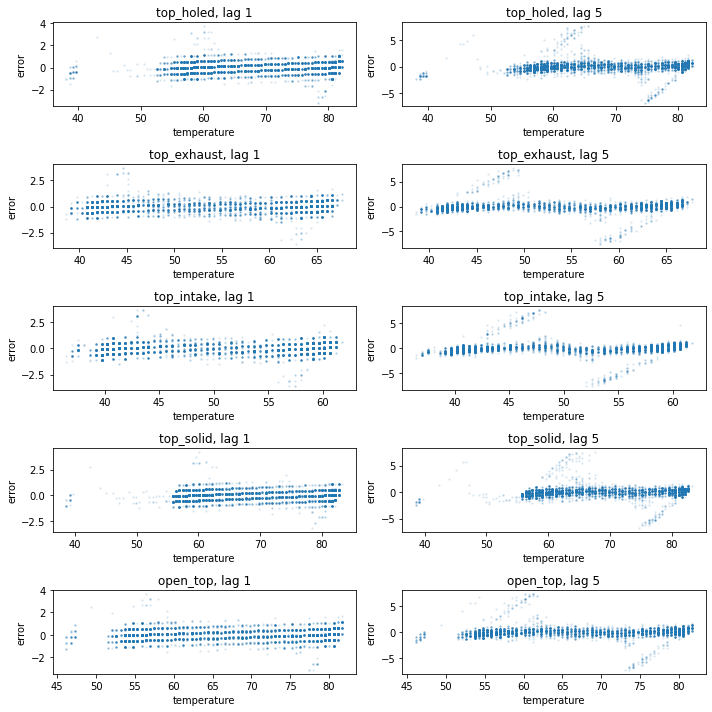

In [12]:
fig, axs = plt.subplots(len(list_of_names), 2, figsize=(10, 10))
for n, name in enumerate(list_of_names):
    for m, lag in zip([0, 1], [1, 5]):
        residuals = (smf
                     .ols(f"temp ~ usage_{lag} + temp_{lag}",
                          data=dt_lag.loc[dt_lag.name == name])
                     .fit()
                     .resid)
        axs[n, m].scatter(dt_lag.loc[dt_lag.name == name].temp,
                       residuals,
                      s=2,
                      alpha=0.1)
        axs[n, m].set_xlabel("temperature")
        axs[n, m].set_ylabel("error")
        axs[n, m].set_title(f"{name}, lag {lag}")
fig.tight_layout()
plt.show()

#### Residuals over time

The graphs below show the residuals over time. If you look closely, you can see negative residuals at the top of the peaks. This means that the model is overestimating temperatures when a cooldown cycle starts. It expects temperatures to remain high because it isn't aware that the CPU usage has been set to 0%.

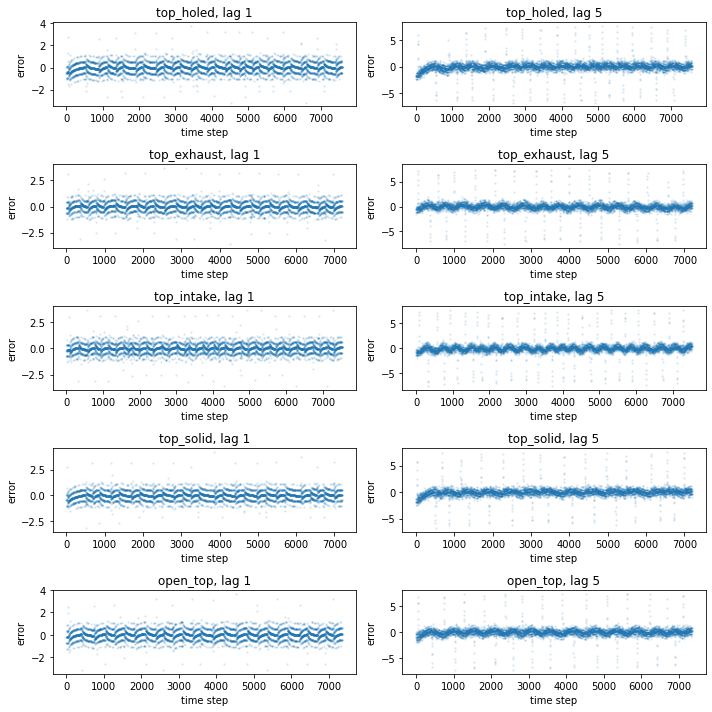

In [13]:
# Set figsize to (20, 20) if you want to zoom in
fig, axs = plt.subplots(len(list_of_names), 2, figsize=(10, 10))
for n, name in enumerate(list_of_names):
    for m, lag in zip([0, 1], [1, 5]):
        residuals = (smf
                     .ols(f"temp ~ usage_{lag} + temp_{lag}",
                          data=dt_lag.loc[dt_lag.name == name])
                     .fit()
                     .resid)
        axs[n, m].scatter(np.arange(len(dt_lag.loc[dt_lag.name == name])),
                       residuals,
                      s=2,
                      alpha=0.1)
        axs[n, m].set_xlabel("time step")
        axs[n, m].set_ylabel("error")
        axs[n, m].set_title(f"{name}, lag {lag}")
fig.tight_layout()
plt.show()

In [14]:
results = smf.ols("""temp ~ usage_1 + temp_1
                        + temp_1:top_solid + temp_1:top_holed
                        + temp_1:top_intake + temp_1:top_exhaust""",
                      data=dt_lag).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.750e+06
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:53:49   Log-Likelihood:                -25908.
No. Observations:               36857   AIC:                         5.183e+04
Df Residuals:                   36850   BIC:                         5.189e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.4558      0

### Getting a rough idea of heat dissipation

We can use the coefficients to get an idea of how much heat each case top dissipates per second.

The fans don't get rid of that much extra heat, but it's enough to prevent temperatures from building up in the case.

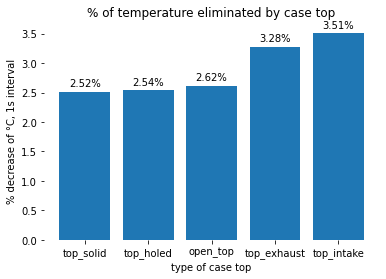

In [15]:
temp_lag = "temp_1"

coefs = results.params

effectiveness = {
    "open_top" : 1 - coefs[temp_lag],
    "top_solid" : 1 - coefs[temp_lag] - coefs[f"{temp_lag}:top_solid"],
    "top_holed" : 1 - coefs[temp_lag] - coefs[f"{temp_lag}:top_holed"],
    "top_intake" : 1 - coefs[temp_lag] - coefs[f"{temp_lag}:top_intake"],
    "top_exhaust" : 1 - coefs[temp_lag] - coefs[f"{temp_lag}:top_exhaust"]
}

# convert to percentages
effectiveness = {k:100*v for k,v in sorted(effectiveness.items(),
                                           key=lambda x: x[1])}

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f"{round(height, 2)}%",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

rects = plt.bar(effectiveness.keys(), effectiveness.values())
autolabel(rects)
plt.box(False)
plt.title(f"% of temperature eliminated by case top")
plt.xlabel("type of case top")
plt.ylabel("% decrease of °C, 1s interval")
plt.savefig("./images/exp2_percentage_dissipation.png")
plt.show()

### Making predictions from the model

We can use the model to predict what the case temperature will do in a given situation. As long as we provide all of the input variables needed by the model, it will output its predicted temperature.

The function below predicts a temperature and then feeds that temperature back into the model, up to `time_steps=100` time steps.

In [16]:
# Simulate a time series
def simulate(initial_temp,
             usage_level,
             model,
             temp_name="temp_1",
             usage_name="usage_1",
             dummies = {
                 "top_solid" : 0,
                 "top_holed" : 0,
                 "top_intake" : 0,
                 "top_exhaust" : 0},
             time_steps=100):
    temp_history = [initial_temp]
    for t in range(1, time_steps):
        prediction = float(model.predict(
                {
                    temp_name:temp_history[-1],
                    usage_name:usage_level,
                    **dummies
                }))
        temp_history.append(prediction)
    return(temp_history)

simulate(80, 100, results, time_steps=10)

[80,
 79.9741024907043,
 79.94888249559258,
 79.92432228996925,
 79.90040461284092,
 79.87711265478531,
 79.85443004613762,
 79.83234084548579,
 79.81082952846685,
 79.78988097685638]

#### Simulating an open top case

We can see how long it takes an open-top case to cool down and warm up.

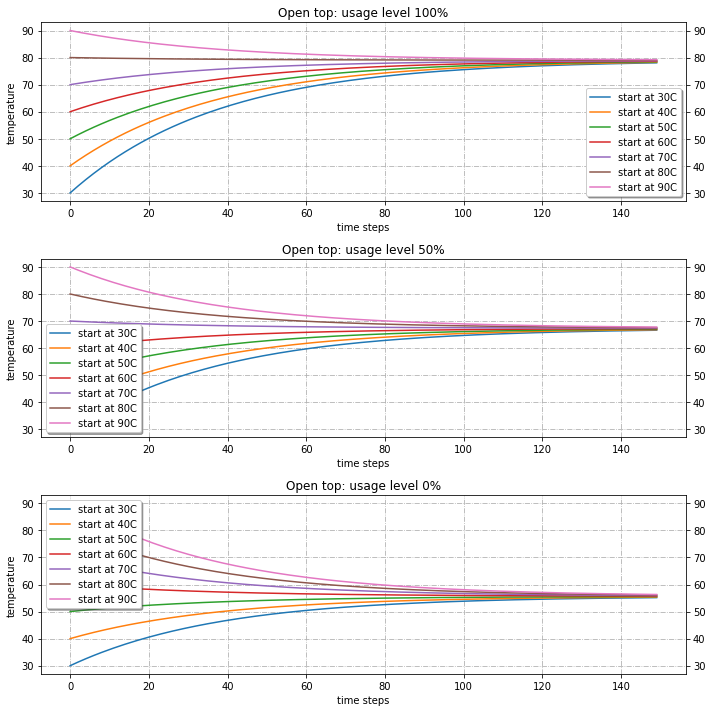

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
for n, usage in enumerate([100, 50, 0]):
    for initial_temp in [30, 40, 50, 60, 70, 80, 90]:
        axs[n].plot(
            np.arange(150),
            simulate(initial_temp, usage, results, time_steps=150),
            label=f"start at {initial_temp}C")
    # draw a nice legend out of the way
    axs[n].legend(loc='best', shadow=True, fancybox=True)
    # draw a grid in a nice dash-dot style
    axs[n].grid(True, linestyle="-.")
    # also draw the tick marks to the right
    axs[n].tick_params(right=True, labelright=True)
    # title the axes and plots
    axs[n].set_xlabel("time steps")
    axs[n].set_ylabel("temperature")
    axs[n].set_title(f"Open top: usage level {usage}%")
fig.tight_layout()
plt.show()

#### Simulating a case with an intake fan

The case with the intake fan should operate at lower temperatures. It takes noticeably longer to heat up but also cools down faster.

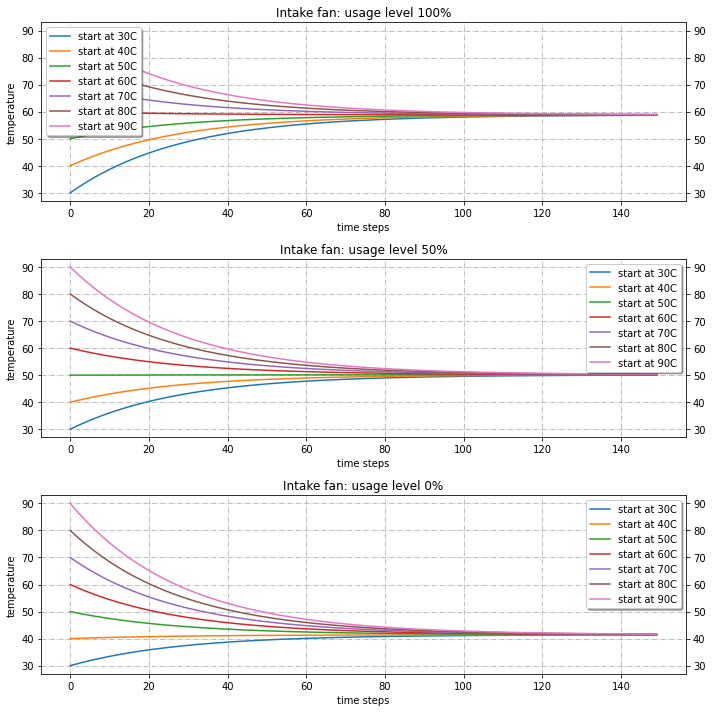

In [18]:
dummies = {"top_solid" : 0,
           "top_holed" : 0,
           "top_intake" : 1,
           "top_exhaust" : 0}

fig, axs = plt.subplots(3, 1, figsize=(10,10))
for n, usage in enumerate([100, 50, 0]):
    for initial_temp in [30, 40, 50, 60, 70, 80, 90]:
        axs[n].plot(
            np.arange(150),
            simulate(initial_temp, usage, results, time_steps=150, dummies=dummies),
            label=f"start at {initial_temp}C")
    # draw a nice legend out of the way
    axs[n].legend(loc='best', shadow=True, fancybox=True)
    # draw a grid in a nice dash-dot style
    axs[n].grid(True, linestyle="-.")
    # also draw the tick marks to the right
    axs[n].tick_params(right=True, labelright=True)
    # title the axes and plots
    axs[n].set_xlabel("time steps")
    axs[n].set_ylabel("temperature")
    axs[n].set_title(f"Intake fan: usage level {usage}%")
fig.tight_layout()
plt.show()